# Figure 3: Modern population t-SNE embedding

In [86]:
import pandas as pd
import skbio
import sklearn
from plotnine import *
import numpy as np
import multiprocessing
from functools import partial
from ete3 import NCBITaxa
from io import StringIO
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa as skbio_mds
from sklearn.manifold import TSNE
from skbio import TreeNode

In [107]:
seed=42
np.random.seed(seed)

In [63]:
modern_sources = pd.read_csv("../../data/sourcepredict/modern_gut_microbiomes_sources.csv")
modern_labels = pd.read_csv("../../data/sourcepredict/modern_gut_microbiomes_labels.csv", index_col=0)

In [115]:
modern_labels.head()

,labels
SRR1175007,Homo_sapiens
SRR042182,Homo_sapiens
SRR061154,Homo_sapiens
SRR061499,Homo_sapiens
SRR063469,Homo_sapiens


In [78]:
def gmpr_size_factor(col, ar):
    pr = np.apply_along_axis(lambda x: np.divide(ar[:, col], x), 0, ar)
    pr[np.isinf(pr)] = np.nan
    pr[pr == 0] = np.nan
    pr_median = np.nanmedian(pr, axis=0)
    return(np.exp(np.mean(np.log(pr_median))))

def GMPR_normalize(df, process):
    """
    Global Mean of Pairwise Ratios
    Chen, L., Reeve, J., Zhang, L., Huang, S., Wang, X., & Chen, J. (2018). 
    GMPR: A robust normalization method for zero-inflated count data 
    with application to microbiome sequencing data. 
    PeerJ, 6, e4600.
    """
    ar = np.asarray(df)

    gmpr_sf_partial = partial(gmpr_size_factor, ar=ar)
    with multiprocessing.Pool(process) as p:
        sf = p.map(gmpr_sf_partial, list(range(np.shape(ar)[1])))

    return(pd.DataFrame(np.divide(ar, sf), index=df.index, columns=df.columns))

## GMPR Normalization

In [ ]:
modern_norm = GMPR_normalize(modern_sources, process=10)

### Dividing dataset intro train and test

In [83]:
training = modern_norm.sample(frac=0.8, axis = 1)

In [84]:
test = modern_norm.drop(training.columns, axis=1)

#### Panel A: Embedding of the training dataset

**Computing the distance matrix**

In [103]:
 def compute_distance(df, rank='species'):
        """
        Sample pairwise distance computation
        Args:
            - rank(str): Taxonomics rank to keep for filtering OTUs
        """

        # Getting a single Taxonomic rank
        ncbi = NCBITaxa()
        only_rank = []
        for i in list(df.index):
            try:
                if ncbi.get_rank([i])[i] == rank:
                    only_rank.append(i)
            except KeyError:
                continue
        df_rank = df.loc[only_rank, :].T
        tree = ncbi.get_topology(list(df_rank.columns), intermediate_nodes=False)
        newick = TreeNode.read(StringIO(tree.write()))
        df_wu = beta_diversity("weighted_unifrac", counts=df_rank.values.astype(int), ids=list(df_rank.index), otu_ids=[str(i) for i in list(df_rank.columns)], tree=newick)
        df_wu = df_wu.to_data_frame()
        return(df_wu)

In [105]:
training_wu_df = compute_distance(training)

**TSNE Embedding**

In [109]:
tsne = TSNE(metric='precomputed',n_components=2, random_state=seed)
train_embed = tsne.fit(np.matrix(training_wu_df))

In [113]:
train_embed = pd.DataFrame(train_embed.embedding_, columns = ['DIM1','DIM2'], index = training_wu_df.index)

In [117]:
train_embed_plot =train_embed.merge(modern_labels, left_index=True, right_index=True)

In [118]:
train_embed_plot.head()

,DIM1,DIM2,labels
SRR063471,24.741173,-4.753068,Homo_sapiens
SRR7658617,-5.958518,-11.006940,Homo_sapiens
SRR5899013,-9.917368,-3.235994,Homo_sapiens
SRR1761700,1.706702,-1.039228,Homo_sapiens
SRR7658630,-4.149984,-0.303667,Homo_sapiens


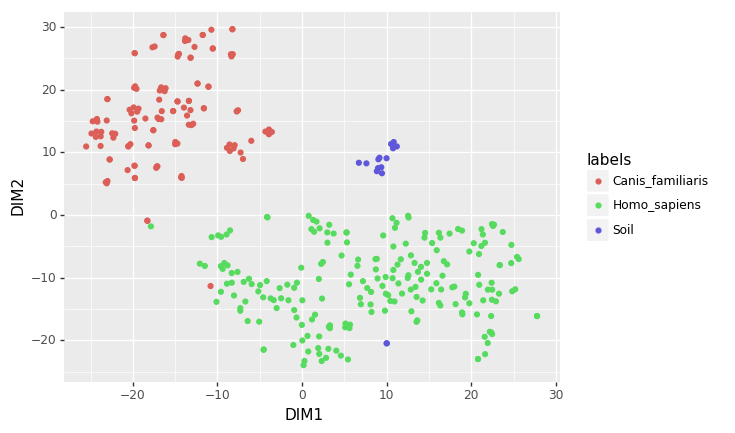

<ggplot: (8768918076771)>

In [120]:
ggplot(train_embed_plot, aes(x='DIM1',y='DIM2')) + geom_point(aes(color='labels'))